# Exercise 4


Consider the following parabolic problem:

\begin{equation}
    \left\{
	\begin{array}{rcl}
		u_t - u_{xx} = f & \text{in }\mathbb T\times\Omega, \\
		u(t,-1) \equiv 1 & \text{for all }t\in\mathbb T, \\
		u(t,1) \equiv 3 & \text{for all }t\in\mathbb T, \\
		u(0,x) = u_0(x) & \text{for all }x\in\Omega,
	\end{array}
    \right.
\end{equation}

where $\mathbb T=(0,T)$, $\Omega=(-1,1)$, and
$$
	f(t,x) := \cos\left(\frac{\pi}{2}x\right)\left( - 1+\frac{\pi^2}{4}\right)e^{-t}, \qquad
	u_0(x) := 2 + x + \cos\left(\frac{\pi}{2} x \right),
$$
for all $t\in\mathbb T$ and $x\in\Omega$.

The goal of this exercise is to approximate the solution of this equation using the finite element method with piecewise linear elements on a uniform grid (i.e., the dear old hat functions) with step length $h>0$.
We recommend you to review section III.9 from the script for the notation and implementation.

### a)

Create a function ```get_rhs``` that, given the step size $h>0$ and a time $t\geq 0$, returns the value of the space-discretized right hand side vector $f_h(t)\in\mathbb{R}^N$ at time $t$.

In [74]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.integrate import fixed_quad
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix

def f(t,x):
    return np.cos( np.pi / 2 * x ) * ( 1 + np.pi ** 2 / 4 ) * np.exp(-t)

def u(t,x):
    return 2 + x + np.cos( np.pi / 2 * x ) * np.exp( - t )

def u0(x): return u(0,x)


def get_rhs( x, t , f  ):
    h = 2 / (len(x)-1)
    f_x = lambda x1: f(t,x1)  # variable separation f = X(x)T(t)
    f_n = []
    for i in range(len(x)-2):
        hat1 = lambda x2: (x2-x[i])/h    # half hat function 
        hat2 = lambda x3: (x[i+2]-x3)/h  # half hat function 
        F1 = lambda x4: f_x(x4) * hat1(x4)  # f * hat1
        F2 = lambda x5: f_x(x5) * hat2(x5)  # f * hat2
        Fv = fixed_quad( F1,x[i],x[i+1],n=20 )+fixed_quad( F2,x[i+1],x[i+2],n=20 )     # F(v)  
        f_n.append( Fv[0] )
    return np.array(f_n) 

    

### b)
Create a function ```get_ODE``` that returns the matrices $M_h,A_h\in\mathbb{R}^{N,N}$ of the ODE corresponding to the space-discretized system for a given step size $h>0$.

In [75]:
def get_A( x ):
    h = 2 / (len(x)-1)
    main_diag = 2 * np.ones(len(x)-2)/h
    secondary_diag = -np.ones(len(x)-3)/h
    A_h = diags([main_diag,secondary_diag,secondary_diag],[0,1,-1])
    return A_h

def get_M( x ):
    h = 2 / (len(x)-1)
    main_diag = (2*h/3) * np.ones(len(x)-2) 
    secondary_diag = (h/6) * np.ones(len(x)-3) 
    M_h = diags([main_diag,secondary_diag,secondary_diag],[0,1,-1])
    return M_h

def get_ODE(x):
    return get_M(x), get_A(x)



### c)
Recover the function ```theta_scheme``` implemented for Homework sheet 7, and modify it so that you can use it in this setting.

In [76]:
def theta_scheme( M,A, u_hk, f_h,  dt, theta = 0):
    inv_M = spsolve(csc_matrix(M),csc_matrix(diags(np.ones(19),0)))  # inverse of M_h
    F_h = inv_M @ f_h   # (inverse of M_h) * f_h
    L_h = inv_M @ A     # (inverse of M_h) * A_h
    b = F_h - ( 1 - theta ) * ( L_h @ u_hk ) + u_hk / dt       # b in theta scheme
    a = diags( np.ones( L_h.shape[0] )/dt , 0 ) + theta * L_h  # A in theta scheme
    return spsolve(csc_matrix(a),b)


### d)

Construct the space discretized problem with step size $h=1/10$ and compute the discrete solution at the times $t=0,1,2,3$, using both the explicit Euler method ($\theta=0$) and the implicit Euler method ($\theta=1$), using time step size $\text{d}t=1/20$ and $\text{d}t = 1/600$.
For each value of $\theta$ and $\text{d}t$, plot the discrete solutions at the four different times in the same figure.

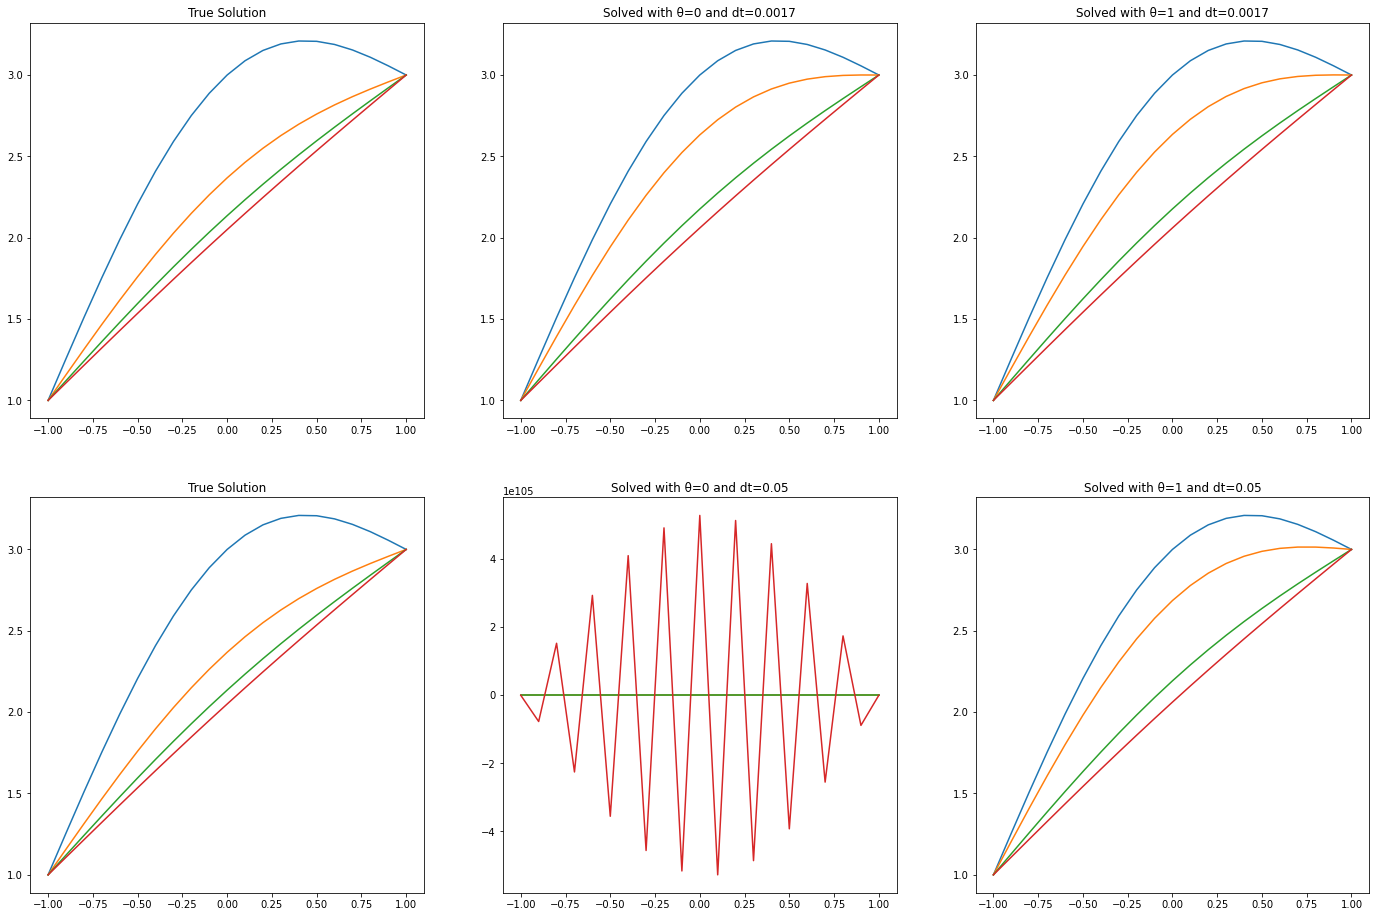

In [77]:
x = np.linspace(-1,1,21)
T = [0,1,2,3,]
dts = [1/600,1/20]
thetas = [0,1]

A = get_A(x)
M = get_M(x)

fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(24,16)) 
ax = [ax1,ax2,ax3,ax4,ax5,ax6]
ax_index = 0
for i in dts:
    for j in T:
        ax[ax_index].plot(x,u(j,x))  # Plot the true solution u(t,x)
        ax[ax_index].set_title('True Solution')
    ax_index += 1  # axes index
    for k in thetas:
        t = 0   # initial time t
        p = 1   # index of list T
        u_k = u0(x)[1:-1]
        ax[ax_index].plot(x,u0(x))
        while t<=T[-1]+i:
            if t >= T[p]:
                ax[ax_index].plot( x, x + 2 +np.insert(u_k,[0,len(u_k)],[0,0]) ) 
                ax[ax_index].set_title('')
                p += 1
            fh = get_rhs( x, t , f )
            u_k = theta_scheme( M,A, u_k, fh,  i, theta = k)
            t += i
        ax[ax_index].set_title('Solved with θ={} and dt={}'.format(k,round(i,4)))
        ax_index += 1
        